# Sentiment Analysis of SVM on Movie Reviews

### 1. Preprocess Text

In [4]:
from bs4 import BeautifulSoup
import re
import pandas as pd
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

# Load the dataset
file_path = 'IMDB Dataset.csv'
data = pd.read_csv(file_path)

def preprocess_text(text):
    # Remove HTML tags - only apply BeautifulSoup if HTML tags are present
    if '<' in text and '>' in text:
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()
    
    # Remove non-letters and convert to lower case
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = text.lower()
    
    return text

# Apply preprocessing to the review column
data['processed_review'] = data['review'].apply(preprocess_text)

### 2. Featrue Extraction

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Initialize vectorizers/models
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
# Placeholder for PPMI and N-gram as they require additional implementation

# Word2Vec model
w2v_model = Word2Vec(sentences=[review.split() for review in data['processed_review']], vector_size=100, window=5, min_count=2, workers=4)

# Feature Extraction: TF-IDF
X_tfidf = tfidf_vectorizer.fit_transform(data['processed_review']).toarray()

# Generating Word2Vec features
def document_vector(doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in w2v_model.wv.index_to_key]
    return np.mean(w2v_model.wv[doc], axis=0) if doc else np.zeros(100)

X_w2v = np.array([document_vector(text.split()) for text in data['processed_review']])

### 3. Dimensionality Reduction

In [6]:
from sklearn.decomposition import TruncatedSVD

# Dimensionality Reduction: PCA on Word2Vec
pca = PCA(n_components=50)
X_w2v_pca = pca.fit_transform(X_w2v)

# Dimensionality Reduction: SVD on TF-IDF
svd = TruncatedSVD(n_components=50)
X_tfidf_svd = svd.fit_transform(X_tfidf)

### 4. Model Training and Evaluation

              precision    recall  f1-score   support

    negative       0.86      0.85      0.85      4961
    positive       0.85      0.86      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Accuracy: 85.71%
Precision: 0.85
F1 Score: 0.86


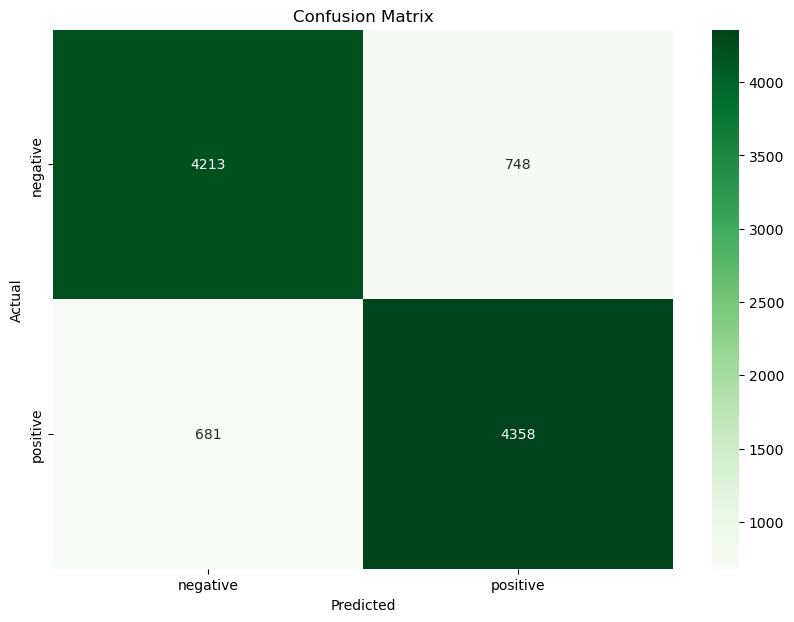

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Encoding labels from 'sentiment' column
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['sentiment'])

# Combining features (optional, requires scaling if combined)
scaler = StandardScaler()
X_combined = np.hstack((X_tfidf_svd, X_w2v_pca))
X_scaled = scaler.fit_transform(X_combined)
y = data['sentiment']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# SVM Model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

# Compute the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='positive')
f1 = f1_score(y_test, y_pred, pos_label='positive')

# Evaluation
print(classification_report(y_test, y_pred))
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("F1 Score: {:.2f}".format(f1))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

### 5. T-SNE Visualization of Review Sentiments

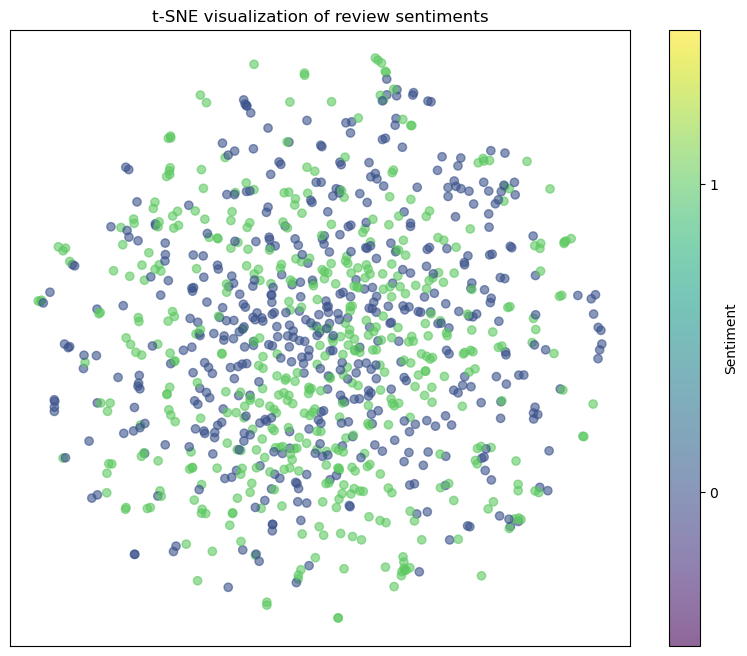

In [10]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Encoding labels from 'sentiment' column
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['sentiment'])

# T-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled[:1000])  # Using a subset for speed

# Create a scatter plot of the t-SNE reduction, color-coded by the encoded labels
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y[:1000], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, ticks=np.arange(len(label_encoder.classes_)), label="Sentiment")
plt.clim(-0.5, len(label_encoder.classes_)-0.5)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.title('t-SNE visualization of review sentiments')
plt.show()


### 6. WordCloud for Reviews

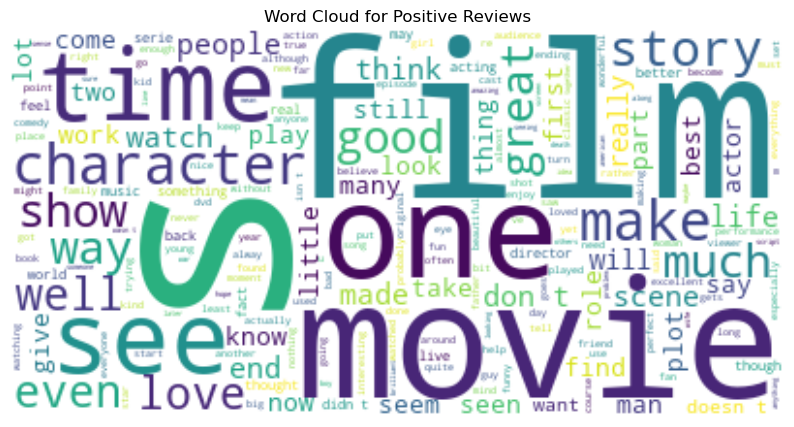

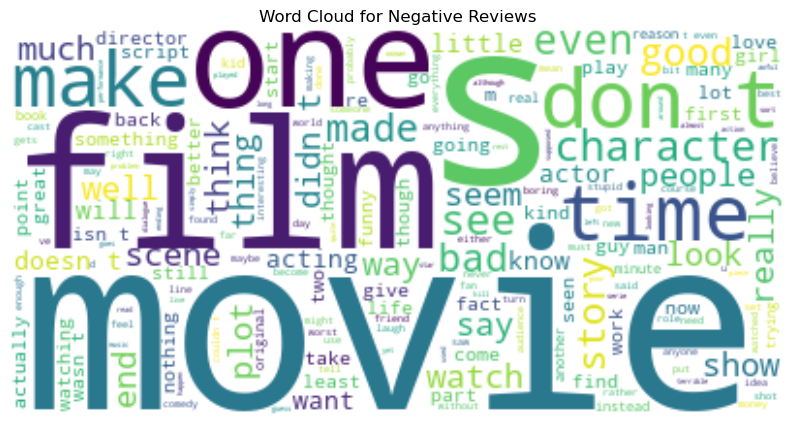

In [11]:
from wordcloud import WordCloud

# Word Cloud for Positive Reviews
positive_words = ' '.join(data[data['sentiment'] == 'positive']['processed_review'])
wordcloud_pos = WordCloud(background_color='white', max_words=200).generate(positive_words)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

# Word Cloud for Negative Reviews
negative_words = ' '.join(data[data['sentiment'] == 'negative']['processed_review'])
wordcloud_neg = WordCloud(background_color='white', max_words=200).generate(negative_words)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

### 7. SVM Performance Analysis

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score
print("F1-score, Precision and Recall Analysis:")
precision = precision_score(y_test, y_pred, pos_label='positive')
f1 = f1_score(y_test, y_pred, pos_label='positive')
recall = recall_score(y_test, y_pred, pos_label='positive')

print("Precision: {:.2f}".format(precision))
print("F1 Score: {:.2f}".format(f1))
print("Recall: {:.2f}".format(recall))

F1-score, Precision and Recall Analysis:
Precision: 0.85
F1 Score: 0.86
Recall: 0.86


### 8. Analysis

##### Model Performance

* Accuracy: The model achieved an overall accuracy of 85.71%. This indicates that the classifier correctly predicts the sentiment of a movie review approximately 86 out of 100 times. This level of accuracy is generally good and suggests that the model is well-fitted to the data.

* Precision and Recall:
    * Negative Reviews:
        * Precision: 0.86 - This score tells us that when the model predicts a review as negative, it is correct 86% of the time.
        * Recall: 0.85 - This means that the model successfully identifies 85% of all actual negative reviews.
    * Positive Reviews:
        * Precision: 0.85 - Indicates that the model's predictions of positive reviews are correct 85% of the time.
        * Recall: 0.86 - Shows that the model identifies 86% of all actual positive reviews.

* F1 Score:
    * The F1 scores for both categories are around 0.85 to 0.86, which suggests a balanced performance between precision and recall. This balance is important in scenarios where both the costs of false positives and false negatives are nearly equal.

##### Results Analysis

* Balanced Performance: The model shows a relatively balanced performance in terms of precision and recall across both sentiment classes. This is ideal in cases where both types of errors (false positives and false negatives) have similar consequences.

* Implications of Metrics:
    * The similar scores in precision, recall, and F1 across both categories suggest that the model does not exhibit a bias toward either sentiment class despite the balanced dataset.

    * The balanced support numbers (number of instances in each class) confirm that the model was trained and evaluated on an evenly distributed dataset, which helps in achieving an unbiased evaluation.

##### Potential Improvement

* 1.Feature Enhancement: While the current feature extraction techniques (likely TF-IDF and possibly Word2Vec) are effective, incorporating more contextual embeddings from models like BERT or GPT could capture deeper semantic meanings, potentially improving recall and precision further, especially for complex sentences or sarcasm.

* 2.Advanced Modeling Techniques: Experimenting with different or more sophisticated machine learning algorithms, such as ensemble methods or deep learning approaches, could further refine the model's predictions, especially in capturing nonlinear relationships.

* 3.Error Analysis: Conducting a thorough error analysis by examining cases where the model predictions were wrong could provide insights into specific areas where the model struggles, such as certain linguistic nuances or less frequent expressions of sentiment.

* 4.Cross-Validation: Implementing more rigorous validation techniques, like k-fold cross-validation, could provide a more robust estimate of model performance and stability across different subsets of data.

##### Conclusion

Overall, the model demonstrates strong performance in sentiment analysis with an ability to fairly and accurately classify both positive and negative reviews. This capability makes it a valuable tool for automatic sentiment analysis tasks, potentially aiding in business decisions, content filtering, and consumer insights analysis. Further refinements and exploration of advanced techniques could elevate its performance, making it an even more effective tool in natural language processing tasks.